<a id='top'></a>
# Using Teranet data for Parking Lot Taxation research

**This notebook presents a sample of how real estate sales data from the Teranet dataset could be used for the research of Parking Lot Taxation.**

This notebook aims to demonstrate how point sales data from Teranet dataset could be combined with data on parking lots and provide spatially-related context on the value of property transactions occuring in the immediate vicinity of a given parking lot in Toronto (or other Ontario cities) in a given period of time (1980-2017).

The proposed logic used in this example:

* Load the shapefile containing the subset of Teranet dataset that contains all transactions recorded in Toronto (spatial information is recorded as coordinates of each transaction)

* Load the dataset of parking (spatial information is recorded as address of each parking lot)

* For this example, the first parking lot (first row) of the parking lot dataset is used to illustrate the potential for connection with the real estate sales data:

    * First row from the parking lot dataset is taken
    
    * Address information for the record is manually converted to GIS coordinates (taken from Google maps)
    
    * A 1,000-m buffer is drawn around the parking lot
    
    * All real estate transactions from the buffer that occured in 2017 are selected from the Teranet dataset, price distribution is displayed. Mean and median price are displayed monthly
    
    * 5-year subset of sales points that fall within the 1,000-m buffer is taken from real estate sales dataset, mean and median price are displayed per annum
    
* The proposed workflow can easily be replicated for any number of parking lots and different time criteria, as long as coordinates of the parking lots can be provided. Size of buffer can be adjusted. Additional attributes can be added to the analysis.

    * The coordinate pair used in this example was entered by hand
    
    * Geocoding can be used to convert parking lot addresses into GIS coordinates.

## Import libraries

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx
import os
from time import time
from shapely.geometry import Point

sns.set()
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
import sys

sys.path.append('../../src')

from io_utils import df_from_csv, add_geom
from plot_utils import map_points

## Load Teranet data

In [3]:
teranet_path = '../../data/teranet/'
os.listdir(teranet_path)

['4_Teranet_lu_predict.csv',
 '1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '4_Teranet_lu_predict.zip',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [4]:
df = df_from_csv(teranet_path + '4_Teranet_lu_predict.csv', parse_dates=['registration_date'])

----- DataFrame loaded
in 100.00 seconds
with 5,188,513 rows
and 81 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_chang

### Take a subset of Teranet records

In [5]:
year = 2014
csd_name = 'Toronto'
mask1 = df['year'] == year
mask2 = df['csdname'] == csd_name
s = df[mask1 & mask2]
print("{0:,} Teranet records from {1} in {2}.".format(len(s), csd_name, year))

96,337 Teranet records from Toronto in 2014.


In [6]:
sgdf = add_geom(s, {'init': 'epsg:4326', 'no_defs': True})


----- Geometry generated from 'X' and 'Y' pairs, GeoDataFrame created!
in 1.70 seconds (0.03 minutes)
with 96,337 rows
and 82 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct

## Load the parking lot data

Presenting an example for one paring lot with coordinates entered by hand. The same process can be repeated automatically for the full parking lot dataset by geocoding addresses into parking lot coordinates.

#### Manually find the coordinates for the address of the first parking lot

Taken from [Google maps](https://www.google.ca/maps/place/480+Bloor+St+W,+Toronto,+ON+M5S+1X8/@43.6645464,-79.4097829,176a,35y,39.45t/data=!3m1!1e3!4m5!3m4!1s0x882b3493e419bf3b:0xdcd9d1cd31f6b92c!8m2!3d43.665594!4d-79.4095102?hl=en), can be geocoded automatically for all parking points instead.




**480 Bloor St.:** -79.409513, 43.665595


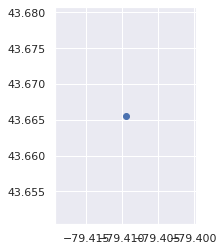

In [7]:
parking_point = pd.DataFrame({'parking_lot': 1}, index=range(1))
parking_point_geom = Point([-79.409513, 43.665595])     # using Point from shapely
parking_point['coordinates'] = parking_point_geom
parking_point_gdf = gpd.GeoDataFrame(parking_point, geometry='coordinates')
parking_point_gdf.crs = {'init': 'epsg:4326', 'no_defs': True}
parking_point_gdf.plot();

## Transactions within a buffer from the target point

### Generate a buffer around the target point

In [8]:
buffer_size = 1000     # size of buffer to draw around the parking lot, in meters
buffer_gdf = gpd.GeoDataFrame(parking_point_gdf.to_crs(epsg=3857).buffer(buffer_size))
buffer_gdf = buffer_gdf.rename(columns={0:'geometry'}).set_geometry('geometry')
buffer_gdf.crs = {'init': 'epsg:3857'}
buffer_gdf = buffer_gdf.to_crs(epsg=4326)
print("{0}m buffer generated around the target point, saved to a new GeoDataFrame.".format(buffer_size))

1000m buffer generated around the target point, saved to a new GeoDataFrame.


### Perform spatial join of the buffer with a Teranet subset

#### Validating CRS

In [9]:
sgdf.crs

{'init': 'epsg:4326', 'no_defs': True}

In [10]:
buffer_gdf.crs

{'init': 'epsg:4326', 'no_defs': True}

#### Perform the spatial join
>Note: EPSG:4326 and WGS 84 represent the [same projection](https://spatialreference.org/ref/epsg/wgs-84/).

In [11]:
t = time()
ps = gpd.sjoin(sgdf, buffer_gdf, how='inner', op='within')
elapsed = time() - t
print('{0:,} transactions occured in {1} within the boundary of the buffer.'.
     format(len(ps), year))
print("Saved in a new geodataframe 'parking_sales_join'. Took {0:,.2f} seconds ({1:,.2f} minutes)."
      .format(elapsed, elapsed / 60))

464 transactions occured in 2014 within the boundary of the buffer.
Saved in a new geodataframe 'parking_sales_join'. Took 4.22 seconds (0.07 minutes).


### Land use of Teranet points

Taking the subset for which predicted land use exists (based on the availability of the features used by the model).

In [12]:
ps['lucr_predict_af'].notnull().sum()

63

In [13]:
ps['lucr_predict_9f'].notnull().sum()

154

In [14]:
mask1 = ps['lucr_predict_9f'].notnull()
ps = ps[mask1]

In [15]:
ps['dmti_lu'].value_counts()

Residential                     110
Government and Institutional     43
Open Area                         1
Name: dmti_lu, dtype: int64

In [16]:
ps['code'].value_counts()

Single Detached House          86
Duplex/Semi-Detached           26
Apartments/Condos/Residence    23
Townhouse                       7
Commercial/Shopping             5
Mix(Commercial Residential)     5
Religious Institutions          1
Strata Townhouses               1
Name: code, dtype: int64

In [17]:
ps['lucr'].value_counts()

detached            64
other               33
duplex_townhouse    33
condo               24
Name: lucr, dtype: int64

In [18]:
ps['lucr_predict_9f'].value_counts()

detached            63
duplex_townhouse    37
other               27
condo               27
Name: lucr_predict_9f, dtype: int64

### Plot the results of  the join

#### With detailed land use from the geography department

In [24]:
ps[['unitno', 'street_number', 'street_name_raw', 
    'xy_prev_sales', 'price_to_med_year',
    'code', 'dmti_lu', 'lu_class', 'lucr', 'lucr_predict_9f', 'lucr_predict_af', 'registration_date', 
    'price_2016', 'xy_total_sales', 'xy_years_to_next_sale', 
    'xy']]

,unitno,street_number,street_name_raw,xy_prev_sales,price_to_med_year,code,dmti_lu,lu_class,lucr,lucr_predict_9f,lucr_predict_af,registration_date,price_2016,xy_total_sales,xy_years_to_next_sale,xy
2867653,NaN,364.0,Huron,2,5.161290,Single Detached House,Government and Institutional,Single Detached House,detached,detached,NaN,2014-02-05,2.050800e+06,3,NaN,-79.4007411478038_43.6643432433889
2868593,NaN,11.0,Madison,1,5.935484,Religious Institutions,Residential,NaN,other,detached,NaN,2014-02-28,2.358420e+06,2,NaN,-79.4026594532116_43.6678044299475
2868865,NaN,85.0,Harbord,27,1.032258,Single Detached House,Residential,NaN,other,other,other,2014-01-10,4.101600e+05,29,-0.000000,-79.40331230167041_43.6625691357189
2868866,205.0,85.0,Harbord,28,1.032258,Single Detached House,Residential,NaN,other,other,NaN,2014-01-10,4.101600e+05,29,NaN,-79.40331230167041_43.6625691357189
2870186,NaN,61.0,Madison,1,4.193548,Duplex/Semi-Detached,Residential,Duplex/Semi-Detached,duplex_townhouse,other,NaN,2014-01-31,1.666275e+06,2,NaN,-79.403539493329_43.6700692517426
2870188,NaN,63.0,Madison,1,4.193548,Duplex/Semi-Detached,Residential,Duplex/Semi-Detached,duplex_townhouse,other,NaN,2014-01-31,1.666275e+06,2,NaN,-79.4035637749456_43.670131976733714
2870194,NaN,65.0,Madison,2,5.904516,Duplex/Semi-Detached,Residential,Duplex/Semi-Detached,duplex_townhouse,detached,NaN,2014-10-20,2.346115e+06,3,NaN,-79.4035912274217_43.6702013011261
2870211,NaN,153.0,Robert,1,3.045161,Single Detached House,Residential,Single Detached House,detached,detached,NaN,2014-02-28,1.209972e+06,2,NaN,-79.4037140562118_43.6635235811181
2870237,401.0,736.0,Spadina,855,1.006452,Single Detached House,Government and Institutional,NaN,other,other,condo,2014-02-14,3.999060e+05,966,-0.000000,-79.40381438475691_43.66577317228371
2870238,401.0,736.0,Spadina,856,1.006452,Single Detached House,Government and Institutional,NaN,other,other,condo,2014-02-14,3.999060e+05,966,0.356164,-79.40381438475691_43.66577317228371


Took 2.35 seconds (0.04 minutes) to plot


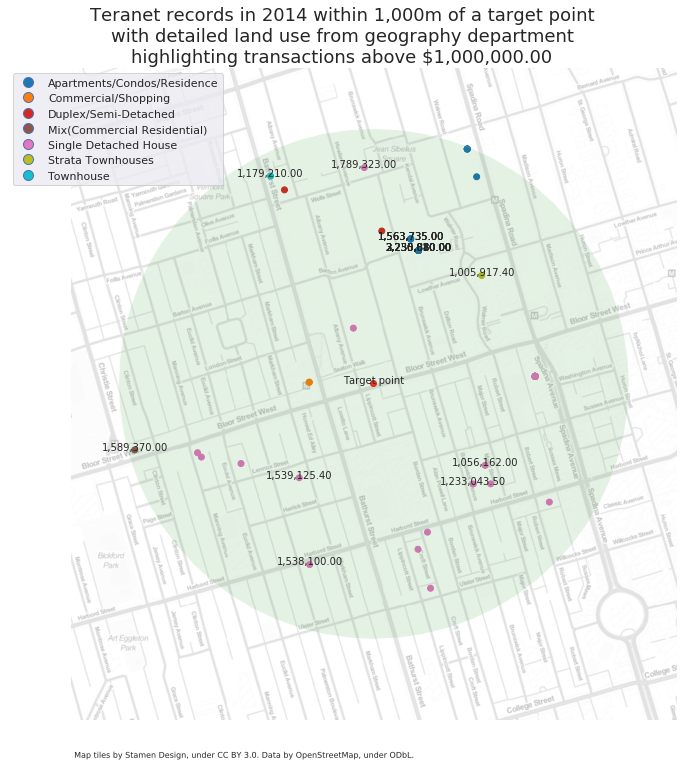

In [62]:
lu_col = 'code'
save_path = 'results/maps/teranet_target_point_' + lu_col + '_' + str(year) + '.png'
max_price = 1000000
highlight_col = 'price_2016'
highlight_idx = ps[highlight_col] > max_price
title = "Teranet records in {0} within {1:,}m of a target point"\
        "\nwith detailed land use from geography department"\
        "\nhighlighting transactions above ${2:,.2f}"\
        .format(year, buffer_size, max_price)

map_points(ps, color_col=lu_col, target_point_gdf=parking_point_gdf, buffer_size=1000,
           caption_idx=highlight_idx, caption_col=highlight_col,
           title=title, output='save', save_path=save_path)

Took 3.26 seconds (0.05 minutes) to plot


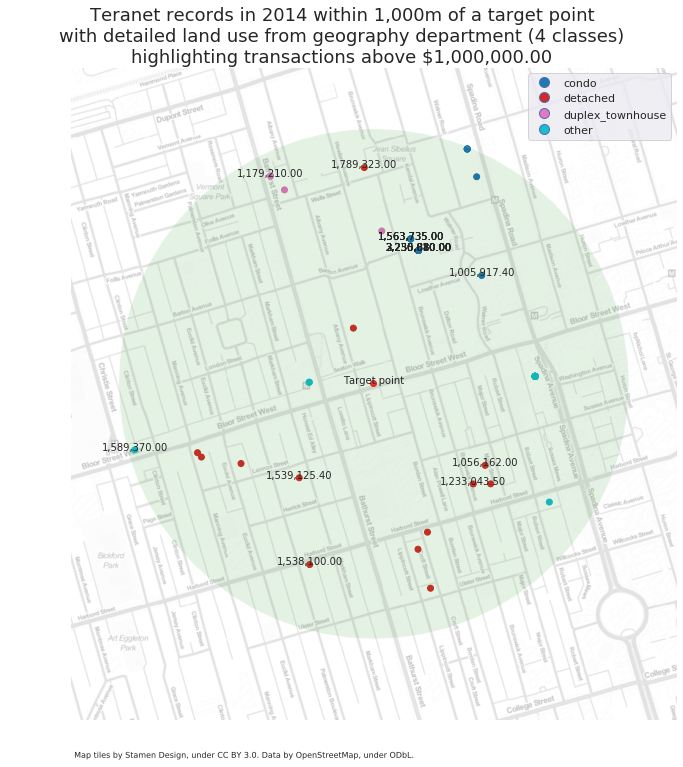

In [63]:
lu_col = 'lucr'
save_path = 'results/maps/teranet_target_point_' + lu_col + '_' + str(year) + '.png'
max_price = 1000000
highlight_col = 'price_2016'
highlight_idx = ps[highlight_col] > max_price
title = "Teranet records in {0} within {1:,}m of a target point"\
        "\nwith detailed land use from geography department (4 classes)"\
        "\nhighlighting transactions above ${2:,.2f}"\
        .format(year, buffer_size, max_price)

map_points(ps, color_col=lu_col, target_point_gdf=parking_point_gdf, buffer_size=1000,
           caption_idx=highlight_idx, caption_col=highlight_col,
           title=title, output='save', save_path=save_path)

## Price distributions

### Mean and median price, general distribution

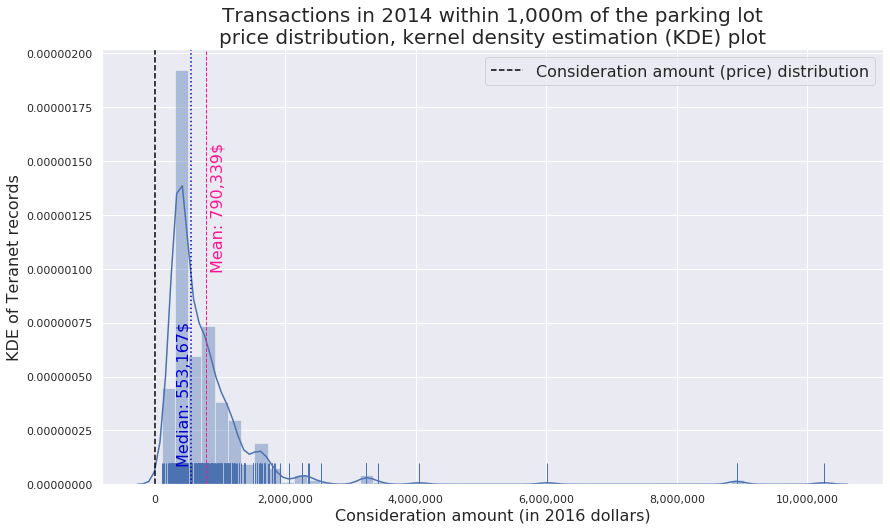

In [108]:
# generate figure and axes
f, ax = plt.subplots(1, figsize=(14, 8))

# plot distribution of price in the subset
sns.distplot(parking_sales_join['price_2016'], kde=True, rug=True, ax=ax)

# calculate mean and median for the subset
sales_mean = int(parking_sales_join['price_2016'].mean())
sales_median = int(parking_sales_join['price_2016'].median())

# plot origin, mean and median
ax.axvline(0, linestyle='--', color='black')
ax.axvline(sales_mean, linestyle='--', linewidth=1, color='deeppink')
ax.axvline(sales_median, linestyle=':', color='mediumblue')
ax.text(sales_mean * 1.08, 0.0000010, 'Mean: {:,}$'.format(sales_mean), color='deeppink', 
        rotation=90, fontsize=16)
ax.text(sales_median * 0.6, 0.0000001, 'Median: {:,}$'.format(sales_median), color='mediumblue', 
        rotation=90, fontsize=16)

# set axis parameters
ax.set_ylabel("KDE of Teranet records", fontsize=16)
ax.set_xlabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.set_title("Transactions in {0} within {1:,}m of the parking lot\n"
             "price distribution, kernel density estimation (KDE) plot".format(year, buffer_size), 
             fontsize=20)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

### Mean and median price, distribution by geog. dept. land use type

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


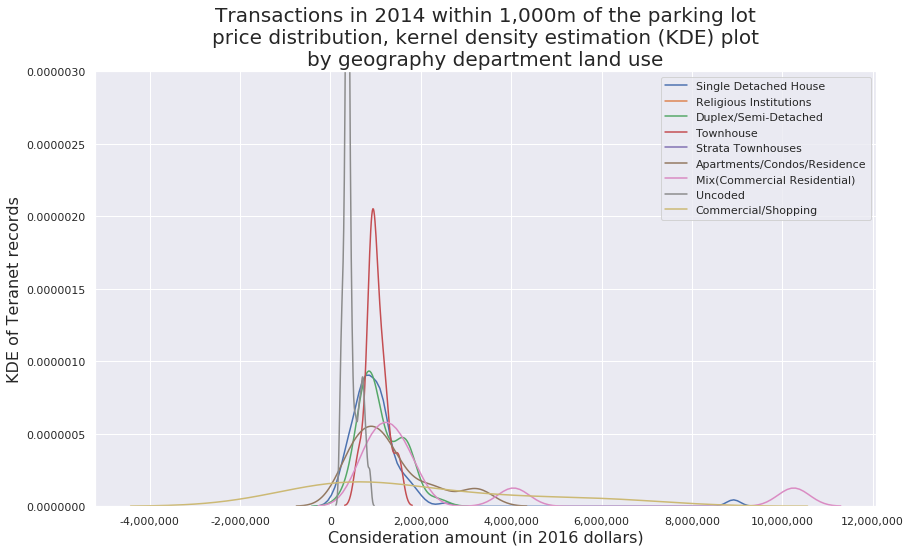

In [109]:
# generate figure and axes
f, ax = plt.subplots(1, figsize=(14, 8))


# plot distribution of price in the subset
list_of_codes = parking_sales_join['code'].unique()
for code in list_of_codes:
    lu_s = parking_sales_join.query('code == "{0}"'.format(code))
    sns.distplot(lu_s['price_2016'], kde=True, rug=False, hist=False, ax=ax, label=code)

# set axis parameters
ax.set_ylabel("KDE of Teranet records", fontsize=16)
ax.set_xlabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.set_title("Transactions in {0} within {1:,}m of the parking lot\n"
             "price distribution, kernel density estimation (KDE) plot".format(year, buffer_size) +
             "\nby geography department land use", 
             fontsize=20)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylim(0, 0.000003)
ax.legend(loc='best')
plt.show()

### Swarmplot by land use geog. dept vs land use DMTI

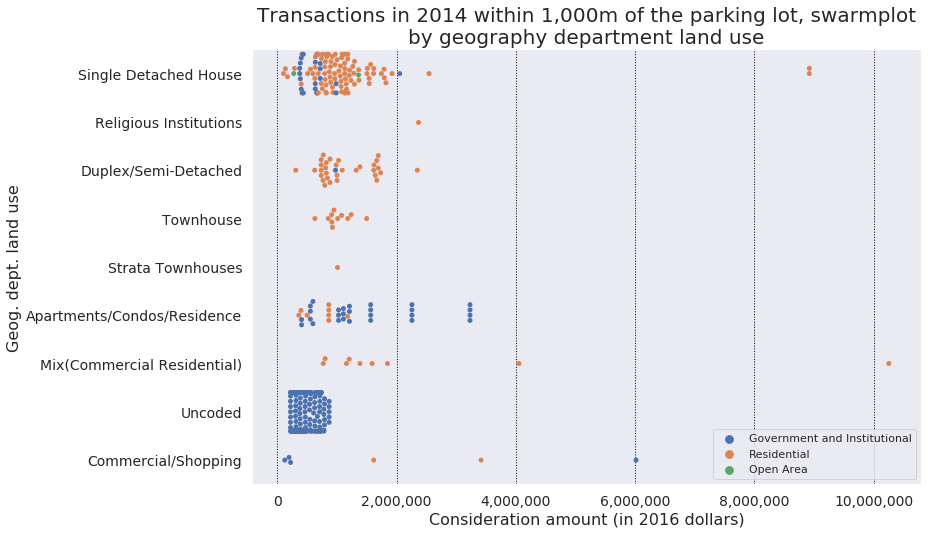

In [12]:
f, ax = plt.subplots(1, figsize=(12, 8))

sns.swarmplot(data=parking_sales_join, y='code', x='price_2016', hue='dmti_lu', ax=ax)

ax.set_title("Teranet records in {0} within {1:,}m of a target point"
             "\nwith land use from DMTI and geo department".format(year, buffer_size),
            fontsize=20)
# set axis parameters
ax.set_ylabel("Geog. dept. land use", fontsize=16)
ax.set_xlabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.legend(['Consideration amount (price) distribution'])
ax.set_title("Transactions in {0} within {1:,}m of the parking lot, swarmplot".format(year, buffer_size) +
             "\nby geography department land use", fontsize=20)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.legend(loc='best')
ax.grid(axis='x', color='black', linestyle=':')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('results/maps/teranet_parking_swarmplot.png', dpi=300, bbox_inches='tight')

### Violinplot by land use geog. dept

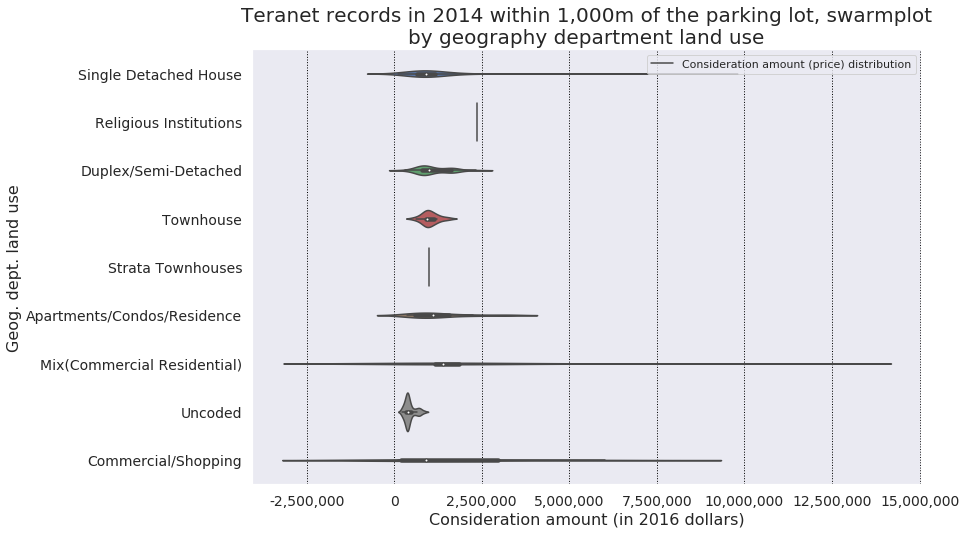

In [13]:
f, ax = plt.subplots(1, figsize=(12, 8))

sns.violinplot(data=parking_sales_join, y='code', x='price_2016', ax=ax)

ax.set_title("Teranet records in {0} within {1:,}m of a target point"
             "\nwith land use from DMTI and geo department".format(year, buffer_size),
            fontsize=20)
# set axis parameters
ax.set_ylabel("Geog. dept. land use", fontsize=16)
ax.set_xlabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.legend(['Consideration amount (price) distribution'])
ax.set_title("Teranet records in {0} within {1:,}m of the parking lot, swarmplot".format(year, buffer_size) +
             "\nby geography department land use", fontsize=20)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.grid(axis='x', color='black', linestyle=':')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('results/maps/teranet_parking_violinplot.png', dpi=300, bbox_inches='tight')

### Time series

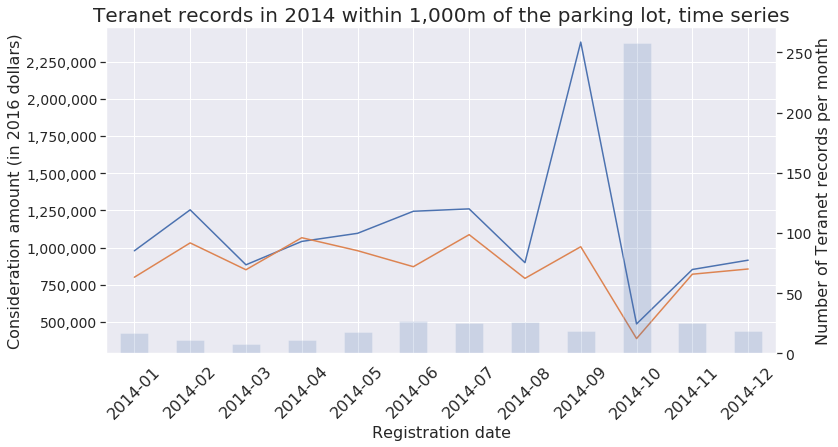

In [180]:
f, ax = plt.subplots(1, figsize=(12, 6))

parking_sales_join.groupby('year_month')['price_2016'].mean().plot(ax=ax)
parking_sales_join.groupby('year_month')['price_2016'].median().plot(ax=ax)
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=14)


ax2 = ax.twinx()
parking_sales_join.groupby('year_month')['price_2016'].count().plot(ax=ax2, kind='bar', alpha=0.2)
plt.yticks(fontsize=14)

# set axis parameters
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("Registration date", fontsize=16)
ax.set_ylabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax2.set_ylabel("Number of Teranet records per month", fontsize=16)
ax.set_title("Teranet records in {0} within {1:,}m of the parking lot, time series".format(year, buffer_size), 
             fontsize=20)

ax2.grid(False)
plt.show()

### Scatterplot

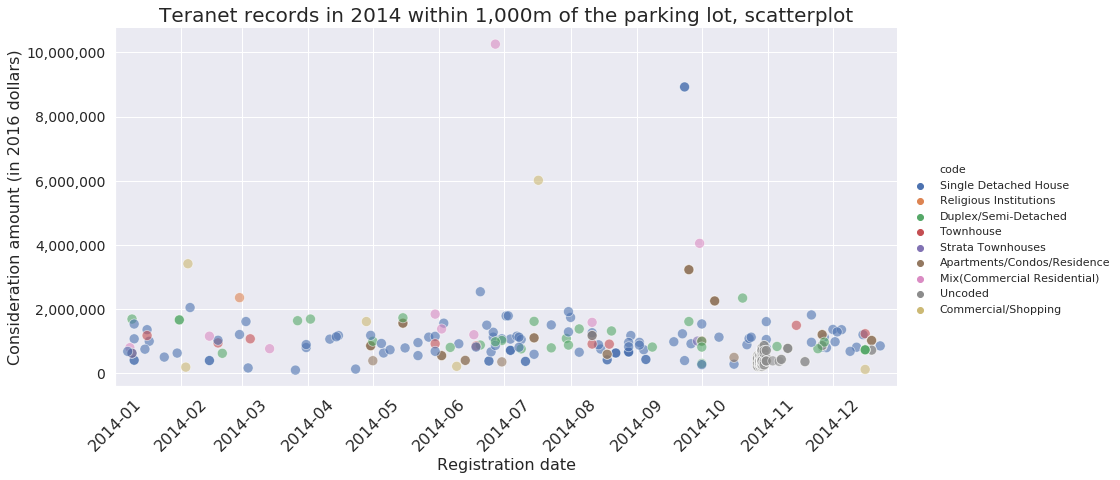

In [183]:
g = sns.relplot(data=parking_sales_join, x='registration_date', y='price_2016', hue='code', s=100,
                height=6, aspect=2, alpha=0.6)

# set axis parameters
ax = g.axes[0][0]
ax.set_xlim('2014-01-01', '2014-12-31')
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=14)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("Registration date", fontsize=16)
ax.set_ylabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.set_title("Teranet records in {0} within {1:,}m of the parking lot, scatterplot".format(year, buffer_size), 
             fontsize=20)

plt.show()